# Beamline Analyzer
### Uses G4Beamline "simple" files as input

## Simulation Configuration Input

*config09_2* is the final update stage of *config09*.

**Detector common in both *_1* and *_2* versions:**
- JGGDet1
- JGGDet2
- JGGDet3
- Det7
- DetT2

**Changes applied:**
- DetT0 was added: more upstream placement of a virtual detector, to both compare the beam flux with StartLine and to trigger events with four detectors (Det7, JGGDet1 + DetT0, DetT2).
- DetT1 was placed more US; it probably won't be used.
- StartLine was added in the making of the TTrees to compare the beam flux with DetT0 as said before.

**Note:** *DetT0 is placed just after the two LArIAT magnets, B1 and B2. DetT1, instead, is placed near LArIAT WCs.* 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import uproot
import math
from glob import glob
import awkward as ak
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
%matplotlib inline

prop_cycle = plt.rcParams['axes.prop_cycle']
_colors = prop_cycle.by_key()['color']

In [3]:
_save_dir = 'plots/lariat_off_JGG_on/T2/'

colors = [
    '#2c5d77',  # Deep Sky Blue
    '#4a7a9b',  # Medium Blue Gray
    '#6a9bb9',  # Light Steel Blue
    '#94c7d6',  # Soft Blue
    '#cbe4eb',  # Slightly Darker Pale Blue 
    '#c1d0da',  # Light Blue Gray
    '#d1dce3',  # Darker Light Gray 
    '#e1e8ed'   # Very Light Gray
]


#colors = plt.cm.Set1(np.linspace(0, 1, 8))

In [4]:
# config05_2, better JGG with field
# f = '/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/config05_2/merged_sim_arcs_beamline_simple_9858of30k.root'
# n_pions = 9858 * 30000
# config = 'config05_2'

# config07_1, BFIELD=0
# f = '/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/config07_1/merged_sim_arcs_beamline_simple_9511of30k_config07_1.root'
# f = '/Users/mdeltutt/OneDrive - Fermi National Accelerator Laboratory/Work/ArCS/beamline/files/merged_sim_arcs_beamline_simple_9511of30k_config07_1.root'
# n_pions = 9511 * 30000
# config = 'config07_1'

# config08_1, BFIELD=0, cryo and LAr
f = '/pnfs/lariat/persistent/users/gcicogna/BeamLineSimOutputs/pos60Amps/config09_2/merged_sim_arcs_beamline_simple_5706of30k_config09_2.root'

n_pions = 5706 * 30000
config = 'config09_2'

det_beam = ['StartLine', 'DetT0']
#det_list = ['DetT0', 'Det7', 'JGGDet1']
det_list = ['DetT2', 'Det7', 'JGGDet1']
det_four = ['DetT0', 'DetT2', 'Det7', 'JGGDet1']


In [5]:
file = uproot.open(f)
print('Detectors:', file.keys())

n_spills = n_pions / 2.5e5
n_hours = n_spills / 60
n_months = n_spills / 60 / 24 / 30

print('Number of pions:', n_pions)
print('Number of spills:', n_spills)
print('Number of hours:', n_hours)
print('Number of months:', n_months)


Detectors: ['VirtualDetector;1', 'VirtualDetector/Det4;1', 'VirtualDetector/Det7;1', 'VirtualDetector/DetT1;1', 'VirtualDetector/DetT2;1', 'VirtualDetector/JGGDet1;1', 'VirtualDetector/JGGDet2;1', 'VirtualDetector/JGGDet3;1']
Number of pions: 150000000
Number of spills: 600.0
Number of hours: 10.0
Number of months: 0.01388888888888889


In [6]:
print('TTree variables:', file[f'VirtualDetector/JGGDet1'].keys())
#print('Number of entries in StartLine:', file[f'VirtualDetector/StartLine'].num_entries)
#print('Number of entries in Det4:', file[f'VirtualDetector/Det4'].num_entries)
#print('Number of entries in DetT0:', file[f'VirtualDetector/DetT0'].num_entries)
print('Number of entries in DetT1:', file[f'VirtualDetector/DetT1'].num_entries)
print('Number of entries in DetT2:', file[f'VirtualDetector/DetT2'].num_entries)
print('Number of entries in Det7:', file[f'VirtualDetector/Det7'].num_entries)
print('Number of entries in JGGDet1:', file[f'VirtualDetector/JGGDet1'].num_entries)

TTree variables: ['x', 'y', 'z', 'Px', 'Py', 'Pz', 't', 'PDGid', 'EventID', 'TrackID', 'ParentID', 'Weight']
Number of entries in Det4: 254388
Number of entries in DetT1: 47847990
Number of entries in DetT2: 14243322
Number of entries in Det7: 13515522
Number of entries in JGGDet1: 29372513


In [7]:
def add_vars_to_df(df):
    '''
    Adds total momentum, as well as theta and phi, to the dataframe
    '''

    px = df['Px'].values
    py = df['Py'].values
    pz = df['Pz'].values

    p = np.sqrt(px**2 + py**2 + pz**2)
    theta = np.arccos(pz / p) / np.pi * 180
    phi = np.arctan2(py, px) / np.pi * 180

    df['P'] = p
    df['theta'] = theta
    df['phi'] = phi

    return df


In [8]:
branches = ['x', 'y', 'z', 'Px', 'Py', 'Pz', 'PDGid', 'EventID', 'TrackID']

dfs = {} # dictionary to store dataframes, list accessible by detector name

#reading data from .root file

#dfs['DetT1'] = file[f'VirtualDetector/DetT1'].arrays(branches, library='pd')
dfs['DetT2'] = file[f'VirtualDetector/DetT2'].arrays(branches, library='pd')
dfs['Det7'] = file[f'VirtualDetector/Det7'].arrays(branches, library='pd')
dfs['JGGDet1'] = file[f'VirtualDetector/JGGDet1'].arrays(branches, library='pd')

#removing duplicates
#dfs['DetT1'] = dfs['DetT1'].drop_duplicates(['EventID', 'TrackID'])
dfs['DetT2'] = dfs['DetT2'].drop_duplicates(['EventID', 'TrackID'])
dfs['Det7'] = dfs['Det7'].drop_duplicates(['EventID', 'TrackID'])
dfs['JGGDet1'] = dfs['JGGDet1'].drop_duplicates(['EventID', 'TrackID'])

#adding total momentum, theta and phi to the dataframes
#dfs['DetT1'] = add_vars_to_df(dfs['DetT1'])
dfs['DetT2'] = add_vars_to_df(dfs['DetT2'])
dfs['Det7'] = add_vars_to_df(dfs['Det7'])
dfs['JGGDet1'] = add_vars_to_df(dfs['JGGDet1'])

# print(dfs['DetT1'])
# print(dfs['JGGDet1'])

# df2.loc[(df2['EventID'] == 29970112.0) & (df2['TrackID'] == 121664.0)]

## Merge TTrees

Merging TTrees for 3 detectors.

Second merge: DetT2 and Det7.
Third merge: (first) and JGGDet1.

The goal is to keep particles that are present in the 3 detectors [DetT2, Det7, JGGDet1], to select particles to trigger on.

The detectors are on-axis with the beam; JGG is ON, LArIAT magnets are OFF.

In [9]:
#First Merge: DetT1 and DetT2 -----------------------------------------------------------------------------------------------------
#df_merged1 = dfs['DetT1'].merge(dfs['DetT2'], on=['EventID', 'TrackID'], how='left', indicator=True, suffixes=('_DetT1', '_DetT2'))

#Drop particles that are not in both detectors
#df_merged1 = df_merged1[df_merged1['_merge'] == 'both']

#Drop PDGid columns (redundant)
#df_merged1 = df_merged1.drop(['PDGid_DetT1'], axis=1)

#Rename PDGid column
#df_merged1 = df_merged1.rename(columns={'PDGid_DetT2': 'PDGid'})

#Second Merge: DetT1+DetT2 (df_merged1) and Det7 -----------------------------------------------------------------------------------------------------
df_merged2 = dfs['DetT2'].merge(dfs['Det7'], on=['EventID', 'TrackID'], how='left', indicator='_merge1', suffixes=('_DetT2', '_Det7'))
df_merged2 = df_merged2[df_merged2['_merge1'] == 'both']
df_merged2 = df_merged2.drop(['PDGid_Det7'], axis=1)

#Third Merge: DetT1+DetT2+Det7 (df_merged2) and JGGDet1 -----------------------------------------------------------------------------------------------------
df = df_merged2.merge(dfs['JGGDet1'], on=['EventID', 'TrackID'], how='left', indicator='_merge_final', suffixes=('_merge1', '_JGGDet1'))
df = df[df['_merge_final'] == 'both']
df = df.drop(['PDGid_JGGDet1'], axis=1, errors='ignore')

df = df.rename(columns={'x':'x_JGGDet1',
                        'y':'y_JGGDet1',
                        'z':'z_JGGDet1',
                        'Px':'Px_JGGDet1', 
                        'Py':'Py_JGGDet1', 
                        'Pz':'Pz_JGGDet1', 
                        'P':'P_JGGDet1', 
                        'theta':'theta_JGGDet1', 
                        'phi':'phi_JGGDet1'})

print(df.columns)


Index(['x_DetT2', 'y_DetT2', 'z_DetT2', 'Px_DetT2', 'Py_DetT2', 'Pz_DetT2',
       'PDGid_DetT2', 'EventID', 'TrackID', 'P_DetT2', 'theta_DetT2',
       'phi_DetT2', 'x_Det7', 'y_Det7', 'z_Det7', 'Px_Det7', 'Py_Det7',
       'Pz_Det7', 'P_Det7', 'theta_Det7', 'phi_Det7', '_merge1', 'x_JGGDet1',
       'y_JGGDet1', 'z_JGGDet1', 'Px_JGGDet1', 'Py_JGGDet1', 'Pz_JGGDet1',
       'PDGid', 'P_JGGDet1', 'theta_JGGDet1', 'phi_JGGDet1', '_merge_final'],
      dtype='object')


In [10]:
# df.query('PDGid==11 and P_Det7 < 100 and theta_Det7 < 10')

In [11]:
def get_values_labels(df, det='JGGDet1', variable='p', p_cut=80):
    '''
    Returns values to plot with their labels

    Args:
        det (str): the detector to plot
        variable (str): the variable to plot
        p_cut (int): momentum cut
    '''

    # Apply a momentum cut
    df_ = df.query(f'P_{det} > {p_cut}')

    # if det == 'Det7':
    #     df_ = df_.query(f'theta_{det} < 1')

    pdg = df_['PDGid'].values

    if variable == 'p':
        var = df_[f'P_{det}'].values
    elif variable == 'theta':
        var = df_[f'theta_{det}'].values
    elif variable == 'phi':
        var = df_[f'phi_{det}'].values
        
    kaons = var[np.abs(pdg)==321]
    positrons = var[pdg==-11]
    electrons = var[pdg==+11]
    muons = var[np.abs(pdg)==13]
    protons = var[np.abs(pdg)==2212]
    pions = var[np.abs(pdg)==211]
    others = var[ (np.abs(pdg)!=321) & (np.abs(pdg)!=11) & (np.abs(pdg)!=13) & (np.abs(pdg)!=2212) & (np.abs(pdg)!=211)]
    gamma = var[np.abs(pdg)==22]
    
    values = [
        others,
        gamma,
        kaons,
        positrons,
        electrons,
        muons,
        protons,
        pions,
    ]

    tot = len(kaons) + len(electrons) + len(positrons) + len(muons) + len(protons) + len(pions)
    tot += len(others)
    tot += len(gamma)
    
    labels = [
        'others' + f', ({len(others) / tot * 100:.1f}%)',
        'gamma' + f', ({len(gamma) / tot * 100:.1f}%)',
        r'$K^\pm$' + f', ({len(kaons):.2e}, {len(kaons) / tot * 100:.1f}%)',
        r'$e^+$' + f', ({len(positrons):.2e}, {len(positrons) / tot * 100:.1f}%)',
        r'$e^-$' + f', ({len(electrons):.2e}, {len(electrons) / tot * 100:.1f}%)',
        r'$\mu^\pm$' + f', ({len(muons):.2e}, {len(muons) / tot * 100:.1f}%)',
        r'$p^\pm$' + f', ({len(protons):.2e}, {len(protons) / tot * 100:.1f}%)',
        r'$\pi^\pm$' + f', ({len(pions):.2e}, {len(pions) / tot * 100:.1f}%)'
    ]

    return values, labels

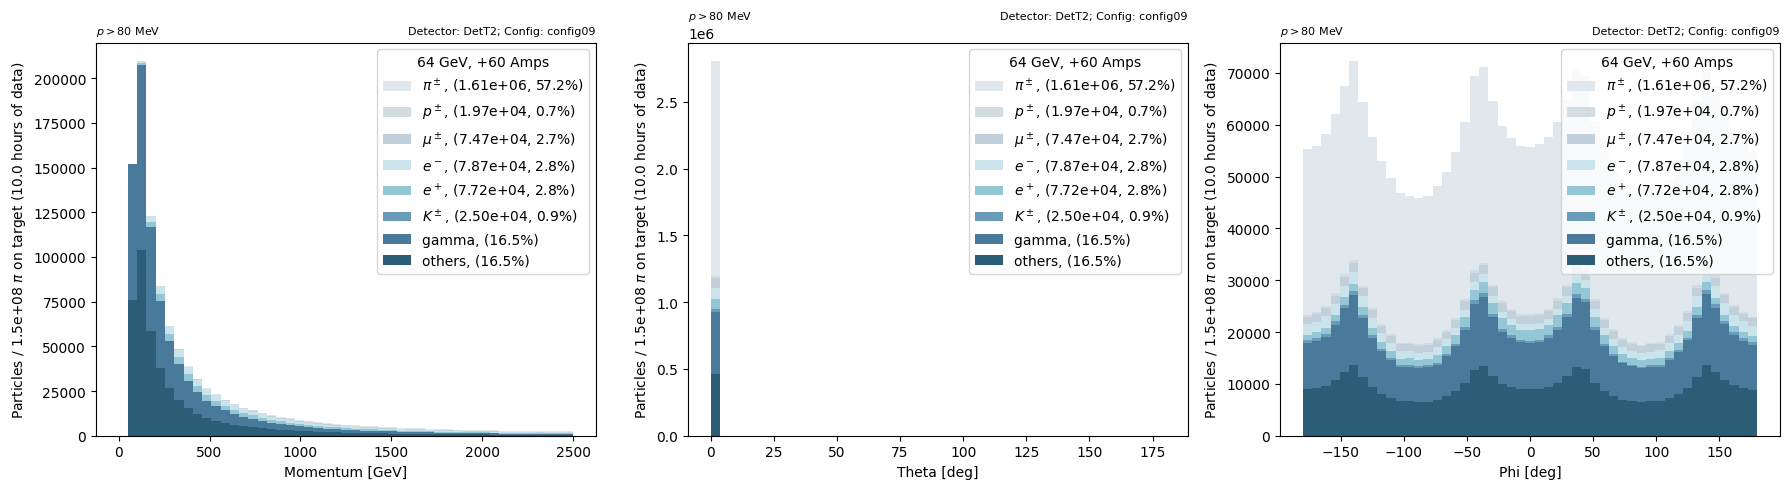

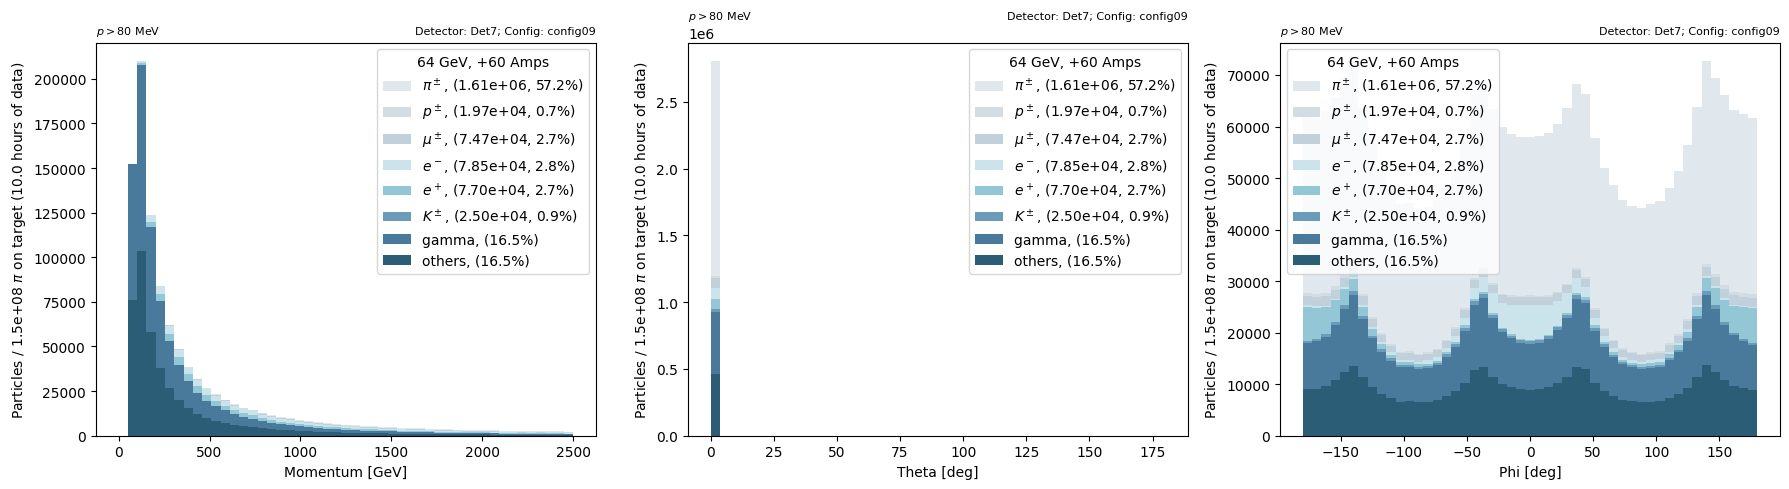

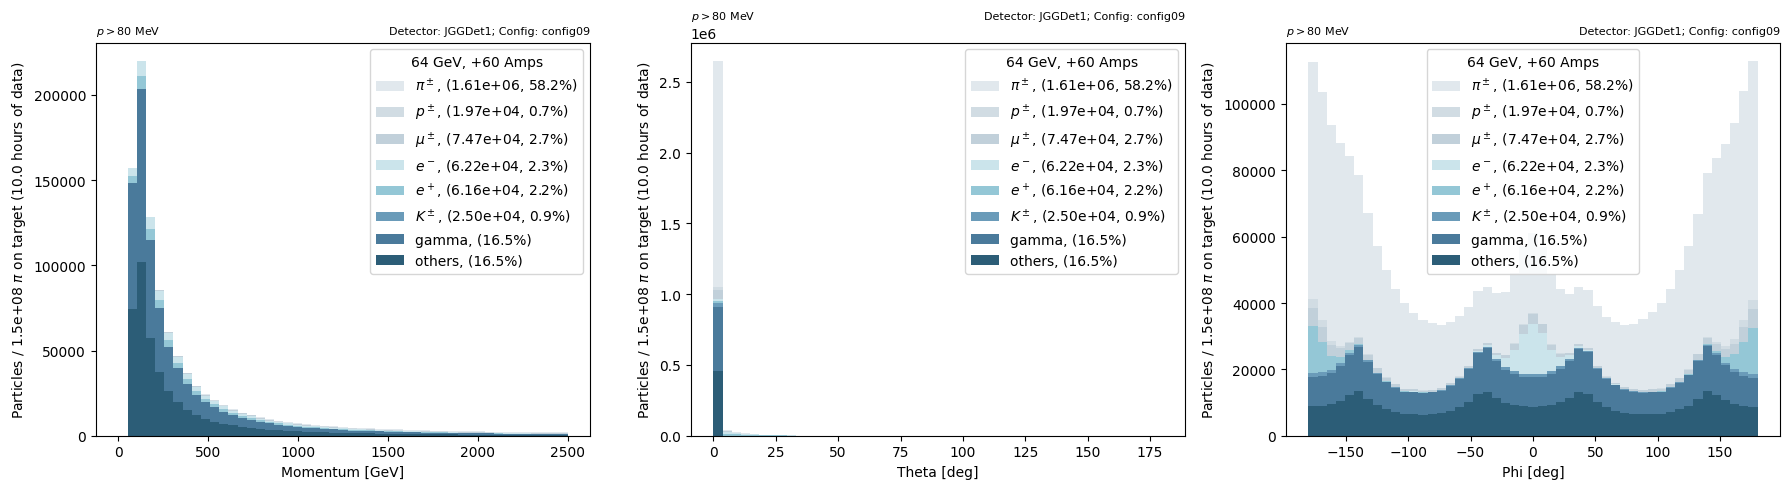

In [12]:
for det in det_list:

    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))

    x_axis = {'p': 'Momentum [GeV]',
              'theta': 'Theta [deg]',
              'phi': 'Phi [deg]'}
    x_bins = {'p': np.linspace(0, 2500, 50),
              'theta': np.linspace(0, 180, 50),
              'phi': np.linspace(-180, 180, 50)}

    for i, variable in enumerate(['p', 'theta', 'phi']):

        p_cut = 80

        values, labels = get_values_labels(df, det, variable, p_cut)
    
        bins = x_bins[variable]
        
        ax[i].hist(values, bins=bins, color=colors, label=labels, stacked=True)
        
        ax[i].legend()
        handles, labels = ax[i].get_legend_handles_labels()
        ax[i].legend(handles[::-1], labels[::-1], title='64 GeV, +60 Amps',)
    
        ax[i].set_xlabel(x_axis[variable])
        ax[i].set_ylabel(f'Particles / {n_pions:.1e} ' + r'$\pi$' + f' on target ({n_hours} hours of data)' )
        ax[i].set_title(f'Detector: {det}; Config: {config}', loc='right', fontsize=8)
        ax[i].set_title(f'$p>{p_cut}$ MeV', loc='left', fontsize=8)
        
        # if det == 'Det7' or det == 'Det8' or 'JGG' in det:
        #     ax[i].set_yscale('log')
    
    plt.tight_layout()
    plt.savefig(_save_dir + f'allspectra_g4blsimpleT_df_{config}_det{det}.jpg')
    plt.show()


In [13]:
 def plot_2d_histogram(ax, x_data, y_data, title, vmin=None, vmax=None):
    x_min, x_max = x_data.min(), x_data.max()
    y_min, y_max = y_data.min(), y_data.max()

    # Set bin edges dynamically with a buffer
    xedges = np.linspace(x_min - 60, x_max + 60, 50)
    yedges = np.linspace(y_min - 60, y_max + 60, 50)

    # Calculate 2D histogram
    hist, xedges, yedges = np.histogram2d(x_data, y_data, bins=[xedges, yedges])

    # Plot the histogram with colormap
    c = ax.pcolormesh(xedges, yedges, hist.T, cmap='viridis', norm=Normalize(vmin=vmin, vmax=vmax))
    ax.set_xlabel('X [mm]')
    ax.set_ylabel('Y [mm]')
    ax.set_title(title, loc='right', fontsize=8)

    # Add colorbar
    fig.colorbar(c, ax=ax, label='Occurrences')

def calculate_global_limits(df, det, pz_threshold=None):
    # Filter data
    x_data = df[f'x_{det}'].values
    y_data = df[f'y_{det}'].values

    if pz_threshold is not None:
        df_filtered = df.query(f'Pz_JGGDet1 > {pz_threshold}')
        x_data = df_filtered[f'x_{det}'].values
        y_data = df_filtered[f'y_{det}'].values

    # Calculate global min and max
    x_min, x_max = x_data.min(), x_data.max()
    y_min, y_max = y_data.min(), y_data.max()

    return x_min, x_max, y_min, y_max

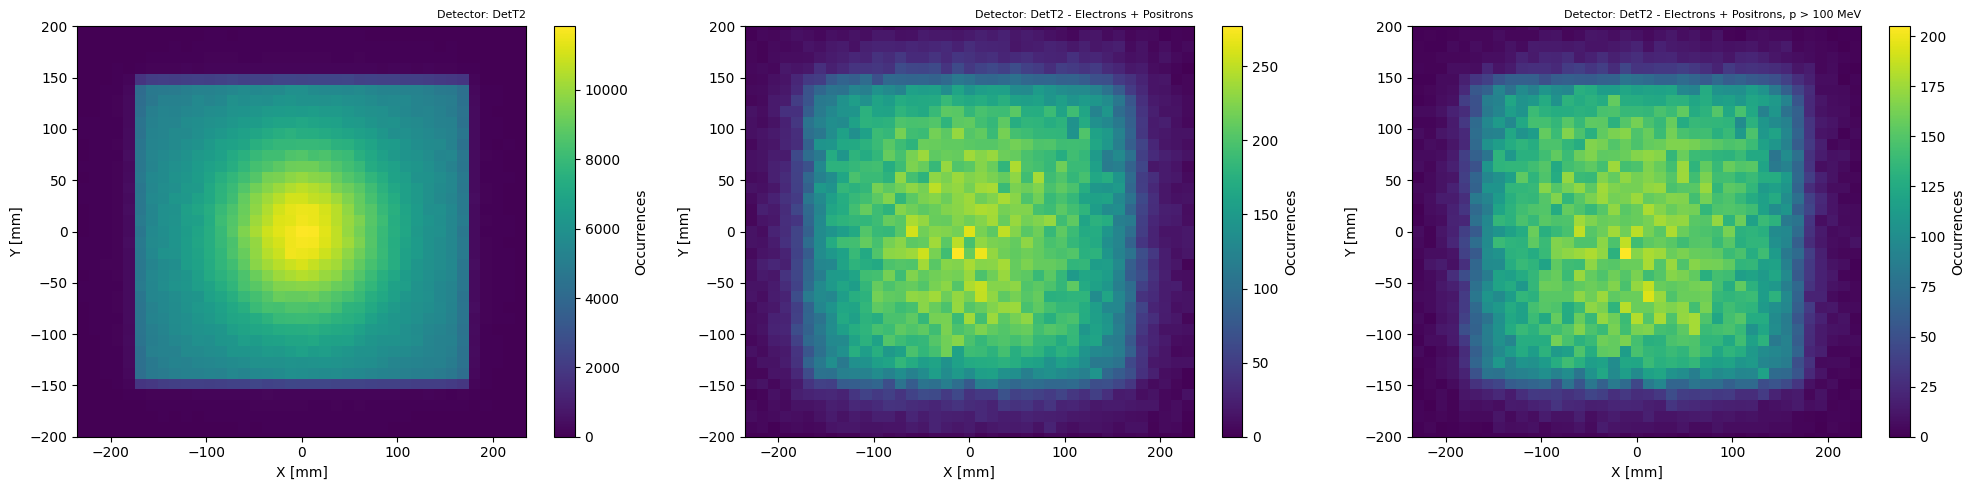

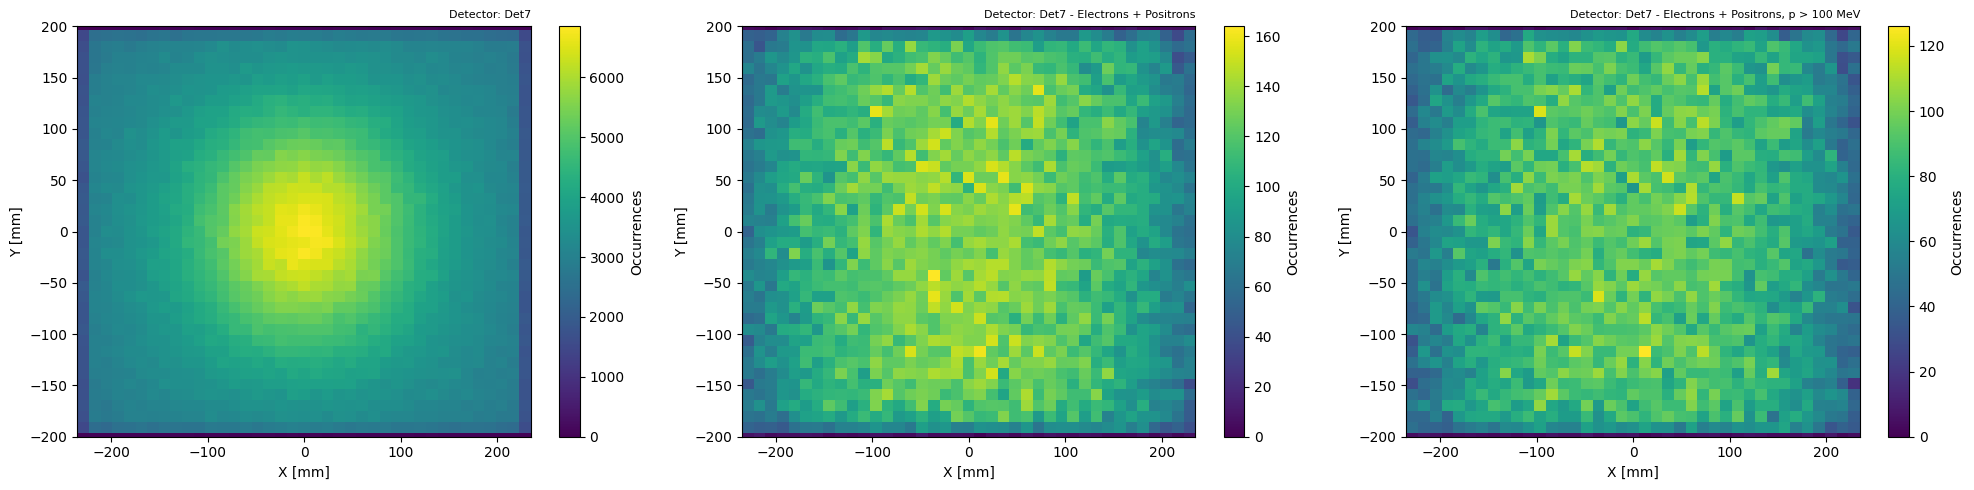

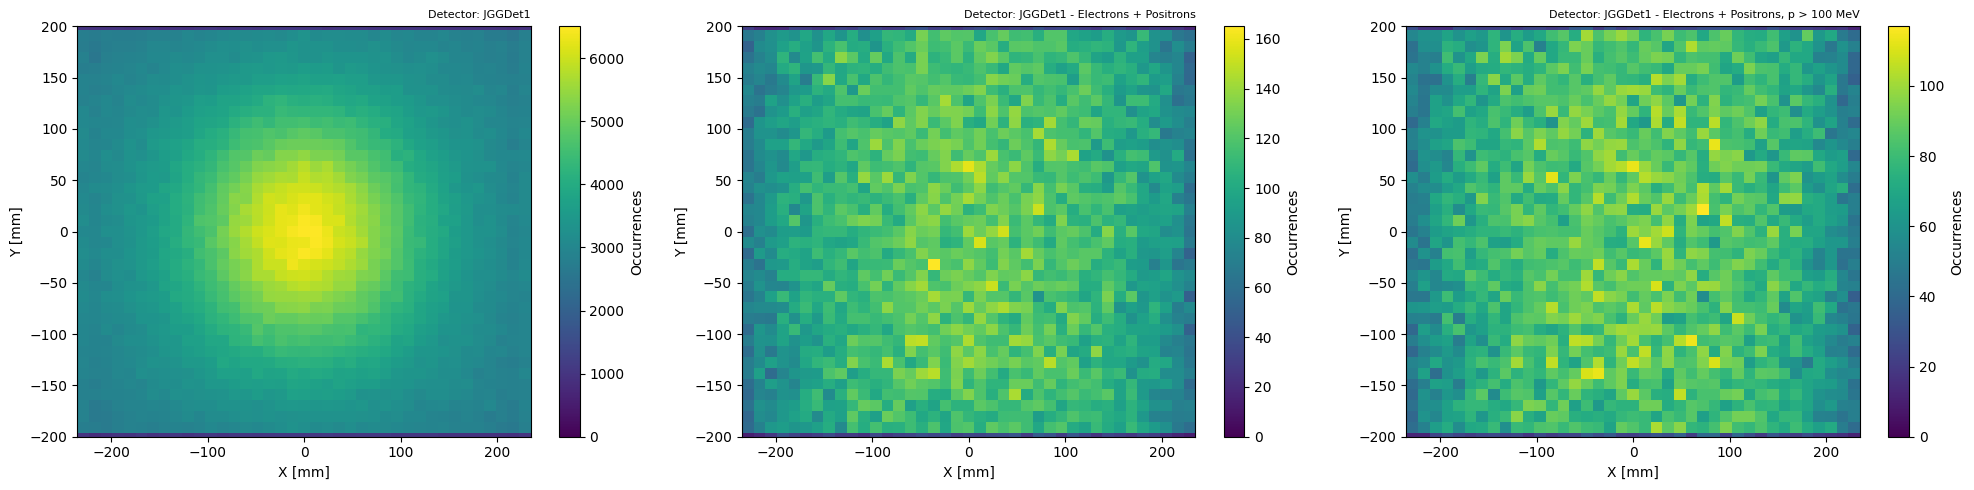

In [14]:
for det in det_list:

    df_e = df[abs(df['PDGid']) == 11]
    
    # Calculate global limits for x and y axes
    x_min_full, x_max_full, y_min_full, y_max_full = calculate_global_limits(df, det)
    x_min_e, x_max_e, y_min_e, y_max_e = calculate_global_limits(df_e, det)
    x_min_p, x_max_p, y_min_p, y_max_p = calculate_global_limits(df, det, pz_threshold=100)

    # Combine limits to ensure consistency across all plots
    x_min_combined = min(x_min_full, x_min_e, x_min_p)
    x_max_combined = max(x_max_full, x_max_e, x_max_p)
    y_min_combined = min(y_min_full, y_min_e, y_min_p)
    y_max_combined = max(y_max_full, y_max_e, y_max_p)

    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20, 5))

    # Full Data
    plot_2d_histogram(ax[0], df[f'x_{det}'].values, df[f'y_{det}'].values,
                      f'Detector: {det}', vmin=0, vmax=None)
    ax[0].set_xlim(x_min_combined, x_max_combined)
    ax[0].set_ylim(y_min_combined, y_max_combined)

    # Electrons + Positrons
    x_data_e = df.query('abs(PDGid) == 11')[f'x_{det}'].values
    y_data_e = df.query('abs(PDGid) == 11')[f'y_{det}'].values
    plot_2d_histogram(ax[1], x_data_e, y_data_e, f'Detector: {det} - Electrons + Positrons',
                      vmin=0, vmax=None)
    ax[1].set_xlim(x_min_combined, x_max_combined)
    ax[1].set_ylim(y_min_combined, y_max_combined)

    # Electrons Only, p > 100 MeV
    x_data_p = df.query('abs(PDGid) == 11 and Pz_JGGDet1 > 100')[f'x_{det}'].values
    y_data_p = df.query('abs(PDGid) == 11 and Pz_JGGDet1 > 100')[f'y_{det}'].values
    plot_2d_histogram(ax[2], x_data_p, y_data_p, f'Detector: {det} - Electrons + Positrons, p > 100 MeV',
                      vmin=0, vmax=None)
    ax[2].set_xlim(x_min_combined, x_max_combined)
    ax[2].set_ylim(y_min_combined, y_max_combined)

    plt.tight_layout()
    plt.savefig(_save_dir + f'posspectra_g4blsimpleT_df_{config}_det{det}.jpg')
    plt.show()

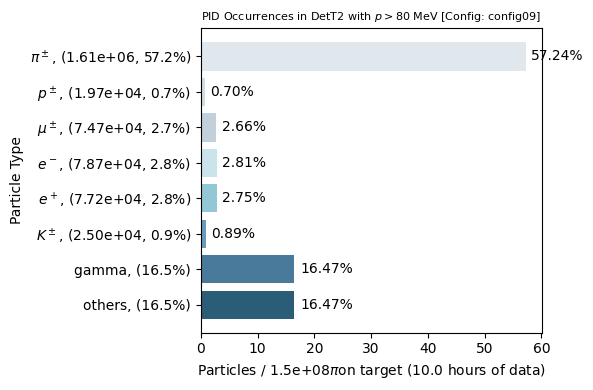

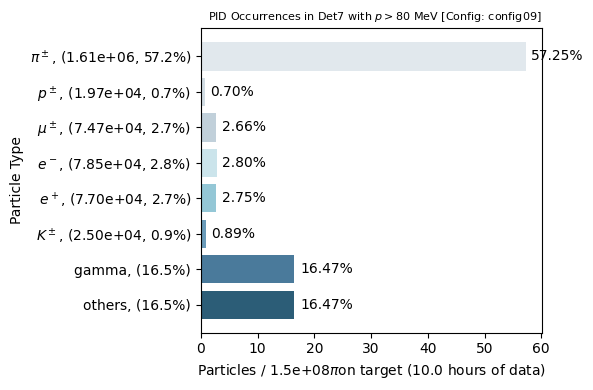

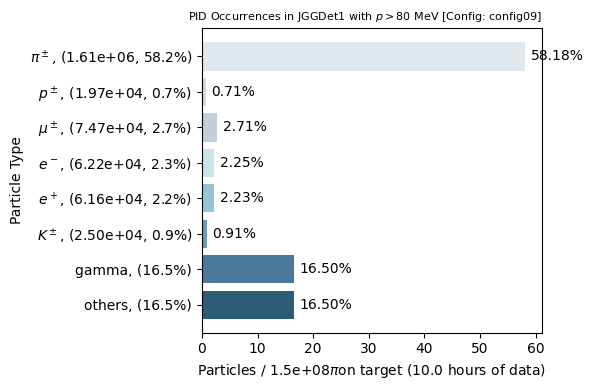

In [15]:
for det in det_list:

    values, labels = get_values_labels(df, det, 'p', p_cut)

    # Creating a single figure for PID
    fig, ax = plt.subplots(figsize=(6,4))

    # Occurrences for each PID
    counts = [len(v) for v in values]
    total_count = sum(counts)
    
    if total_count == 0:
        # Handle division by zero case
        percentages = [0] * len(counts)
    else:
        percentages = [(count / total_count) * 100 for count in counts]

    # Create bar plot with particle counts and their types
    ax.barh(labels, percentages, color=colors)

    # Set labels and title
    ax.set_xlabel(f'Particles / {n_pions:.1e}' + r'$\pi$' + f'on target ({n_hours} hours of data)')
    ax.set_ylabel('Particle Type')
    ax.set_title(f'PID Occurrences in {det} with $p > {p_cut}$ MeV [Config: {config}]', loc='right', fontsize=8)

    # Optionally add value labels on the bars
    for i, v in enumerate(percentages):
        ax.text(v + 1, i, f'{v:.2f}%', color='black', va='center')

    fig.tight_layout()
    fig.savefig(_save_dir + f'pid_g4blsimpleT_df_{config}_det{det}.jpg')
    plt.show()
    

In [25]:
particle_focus = 'Gamma'

# Define the mapping from particle focus to IDs
particle_id_mapping = {
    'Electrons': [11],
    'Positrons': [-11],
    'Gamma': [22],
    'Both (e)': [11, -11],        # Both Electrons and Positrons
}

In [ ]:
print(f"Particle focused on is {particle_focus}")

colors_ = colors[:6]
colors_=colors_[::-1]
#print(len(colors_))

for det in det_list:
    
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))

    # Define momentum ranges and labels
    #momentum_ranges = [(500, np.inf), (400, 500), (300, 400), (200, 300), (100, 200), (0,100)]
    #momentum_labels = ['>500 MeV','400-500 MeV','300-400 Mev','200-300 MeV','100-200 MeV','0-100 MeV']
    momentum_ranges = [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500), (500, np.inf)]
    momentum_labels = ['<100 MeV', '100-200 MeV', '200-300 MeV', '300-400 MeV', '400-500 MeV', '>500 MeV']

    #colors_ = plt.cm.Set1(np.linspace(0, 1, len(momentum_ranges)))
    
    # Define axes for the histograms
    x_axis = {'p': 'Momentum [GeV]', 'theta': 'Theta [deg]', 'phi': 'Phi [deg]'}
    x_bins = {'p': np.linspace(0, 2500, 50), 'theta': np.linspace(0, 180, 50), 'phi': np.linspace(-180, 180, 50)}
    
    # Filter data for ABS pdgid = 11; electrons AND positrons
    #df_focus = df[abs(df['PDGid']) == 11]

     # Ensure particle_focus is a valid key
    if particle_focus not in particle_id_mapping:
        raise ValueError(f"Invalid particle_focus: {particle_focus}")

    # Get the list of IDs for the specified particle_focus
    ids_to_filter = particle_id_mapping[particle_focus]

    #print(ids_to_filter)
    
    # Filter DataFrame based on IDs
    df_focus = df[df['PDGid'].isin(ids_to_filter)]
    
    # Get values and labels for the selected detector and variable
    values, labels = get_values_labels(df_focus, det, 'p', p_cut = 0)
    phi_values, _ = get_values_labels(df_focus, det, 'phi', p_cut = 0)
    theta_values, _ = get_values_labels(df_focus, det, 'theta', p_cut = 0)

    # Flatten the array of arrays, ignoring empty arrays
    flattened_values = np.concatenate([v for v in values if v.size > 0], axis=None)
    flattened_values = np.array(flattened_values, dtype=float)

    # Flatten theta values similarly
    flattened_theta_values = np.concatenate([v for v in theta_values if v.size > 0], axis=None)
    flattened_theta_values = np.array(flattened_theta_values, dtype=float)

    # Flatten phi values similarly
    flattened_phi_values = np.concatenate([v for v in phi_values if v.size > 0], axis=None)
    flattened_phi_values = np.array(flattened_phi_values, dtype=float)

    #Empty array to contain all values (arrays) of each momentum range
    filtered_=[]
    filtered_theta=[]
    filtered_phi=[]

    labels=[]
    
    # Create stacked histograms for momentum ranges in the first subplot
    for i, ((low, high), label) in enumerate(zip(momentum_ranges, momentum_labels)):
        # Filter values based on the current momentum range
        mask = (flattened_values >= low) & (flattened_values < high)

        filtered_values = flattened_values[mask]
        filtered_theta_values = flattened_theta_values[mask]
        filtered_phi_values = flattened_phi_values[mask]

        filtered_.append(filtered_values)
        filtered_theta.append(filtered_theta_values)
        filtered_phi.append(filtered_phi_values)

        labels.append(label)
        
        
    # Plot histograms for each momentum range
    ax[0].hist(filtered_, bins=x_bins['p'], label=labels, color=colors_, histtype='stepfilled', stacked=True)

    # Filter theta values for the same momentum range
    ax[1].hist(filtered_theta, bins=x_bins['theta'], label=labels, color=colors_, histtype='stepfilled', stacked=True)

    # Filter phi values for the same momentum range
    ax[2].hist(filtered_phi, bins=x_bins['phi'], label=labels, color=colors_, histtype='stepfilled', stacked=True)
    
    
    ax[0].set_xlabel(x_axis['p'])
    ax[0].set_ylabel(f'Particles / {n_pions:.1e} ' + r'$\pi$' + f' on target ({n_hours} hours of data)')
    ax[0].set_title(f'Detector: {det}; Config: {config}', loc='right', fontsize=8)
    ax[0].set_title(f'p spectrum for {particle_focus} only', loc='left', fontsize=8)
    ax[0].legend(title='Momentum Range', loc='upper right', framealpha=0.1)
    
    ax[1].set_xlabel(x_axis['theta'])
    ax[1].set_ylabel(f'Particles / {n_pions:.1e} ' + r'$\pi$' + f' on target ({n_hours} hours of data)')
    ax[1].set_title(f'Detector: {det}; Config: {config}', loc='right', fontsize=8)
    ax[1].set_title(f'Theta distribution for {particle_focus} only', loc='left', fontsize=8)
    ax[1].legend(title='Momentum Range', loc='upper right', framealpha=0.1)
    
    ax[2].set_xlabel(x_axis['phi'])
    ax[2].set_ylabel(f'Particles / {n_pions:.1e} ' + r'$\pi$' + f' on target ({n_hours} hours of data)')
    ax[2].set_title(f'Detector: {det}; Config: {config}', loc='right', fontsize=8)
    ax[2].set_title(f'Phi distribution for {particle_focus} only', loc='left', fontsize=8)
    ax[2].legend(title='Momentum Range', loc='upper right', framealpha=0.1)
    
    plt.tight_layout()
    plt.savefig(_save_dir + f'{particle_focus}_spectra_g4blsimpleT_df_{config}_det{det}.jpg')
    plt.show()


Particle focused on is Gamma


Particle focused on is Electrons


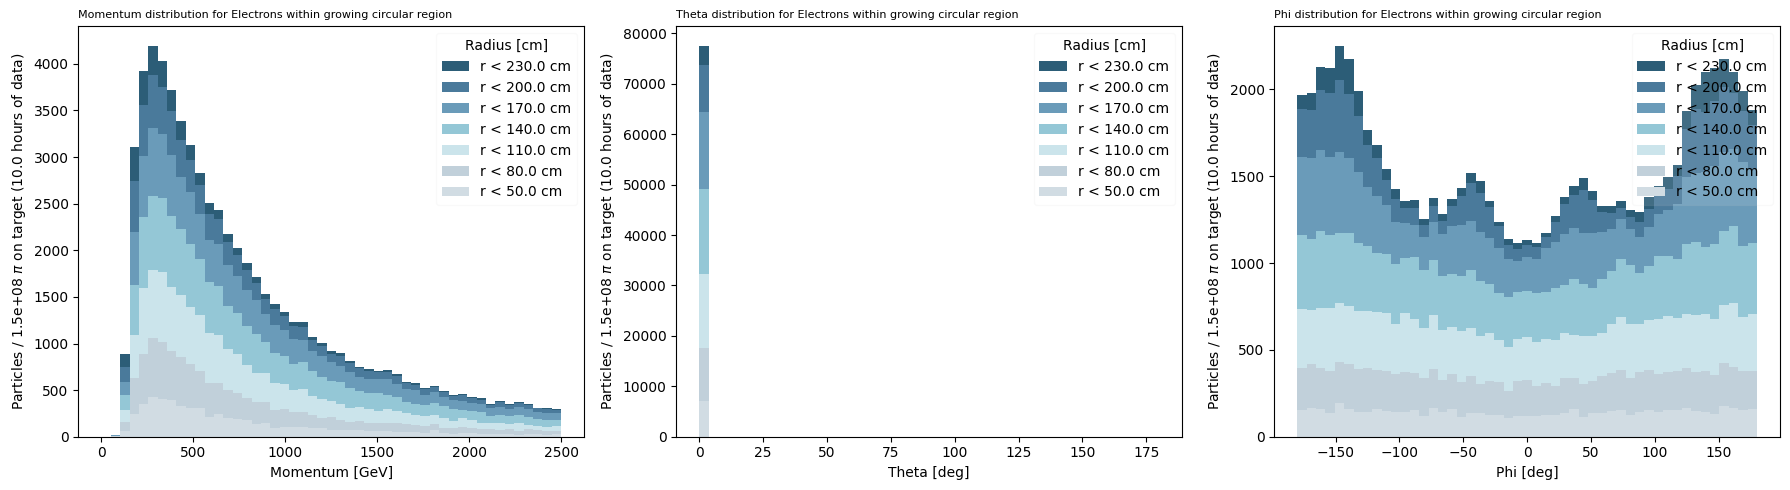

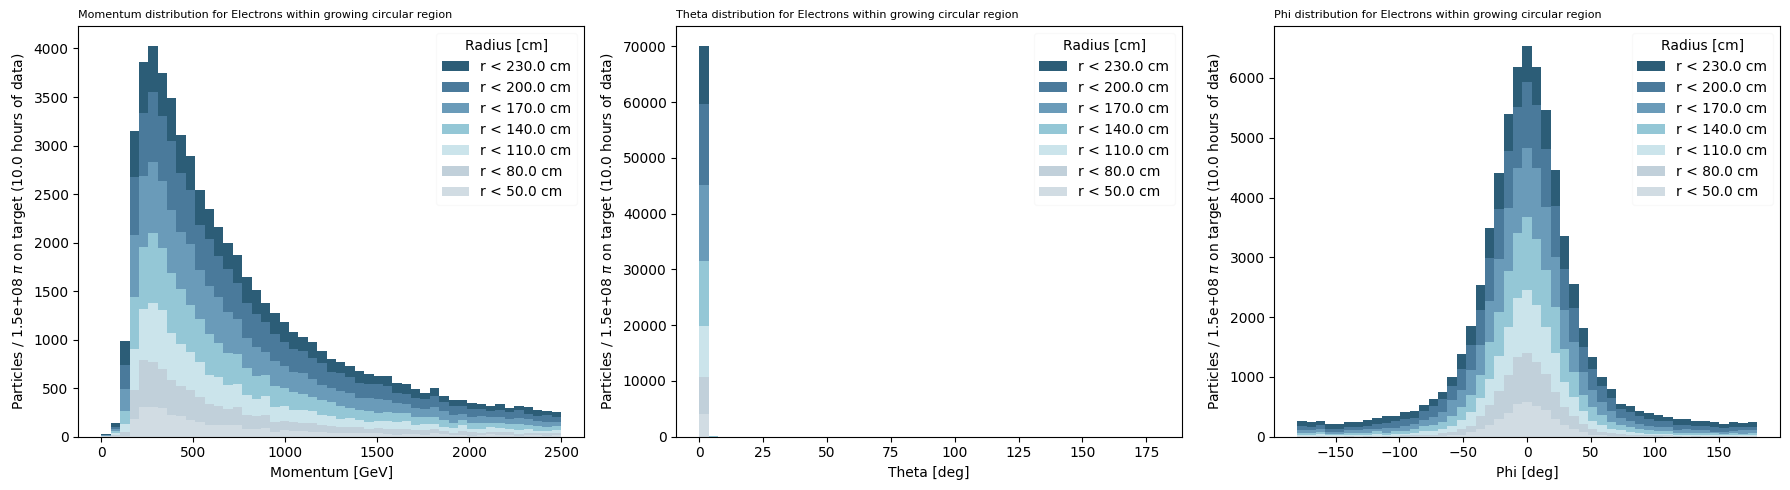

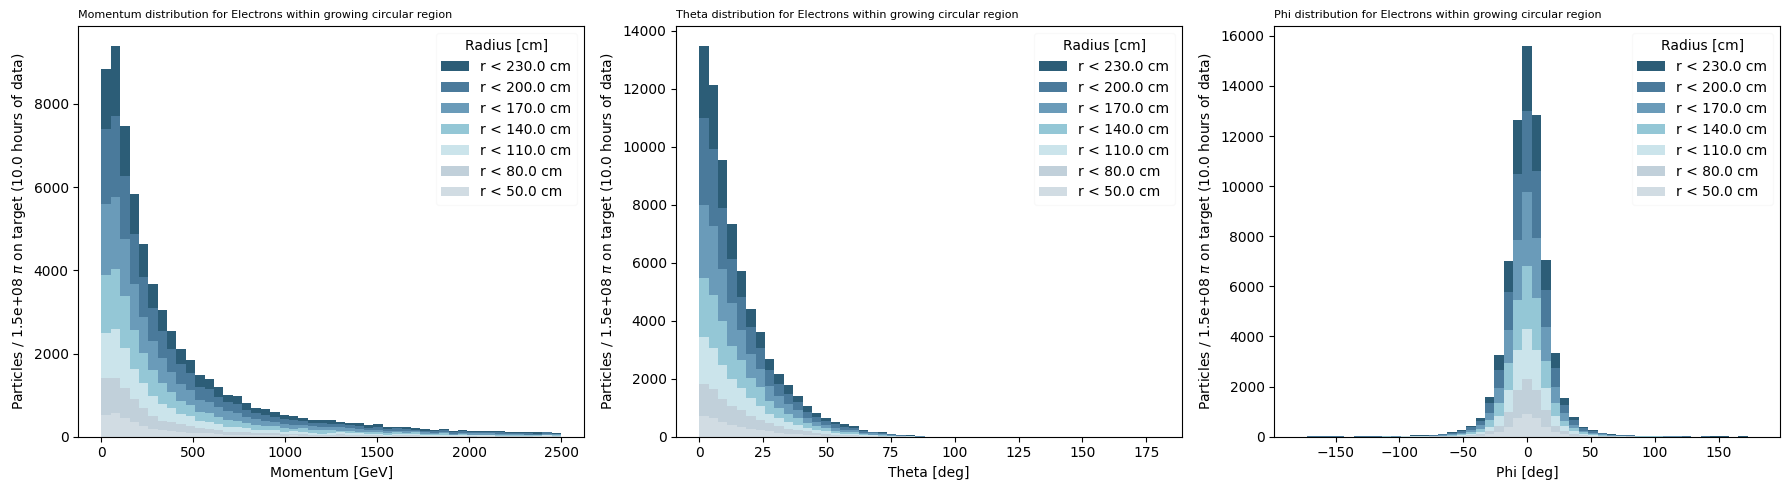

In [22]:
#circular symmetry analysis 

print(f"Particle focused on is {particle_focus}")

for det in det_list: 
    
    detector_center = (0, 0)  # (x0, y0)
    
    # Define maximum radius based on the area of the detector (DetPrime 400 * 470)
    max_radius = np.sqrt(470 * 400 / np.pi)  # cm

        # Define step size for increasing radius (e.g., 10 cm increments)
    radius_steps = np.arange(50, max_radius, 30)
    radius_steps=radius_steps[::-1]
    
     # Ensure particle_focus is a valid key
    if particle_focus not in particle_id_mapping:
        raise ValueError(f"Invalid particle_focus: {particle_focus}")

    # Get the list of IDs for the specified particle_focus
    ids_to_filter = particle_id_mapping[particle_focus]

    #print(ids_to_filter)
    
    # Filter DataFrame based on IDs
    df_focus = df[df['PDGid'].isin(ids_to_filter)]
    
    # Get values for position (assuming you have 'x' and 'y' coordinates of particles)
    x_values = df_focus[f'x_{det}'].values  # x-coordinate of particles
    y_values = df_focus[f'y_{det}'].values  # y-coordinate of particles

     # Get values for position and other parameters
    x_values = df_focus[f'x_{det}'].values
    y_values = df_focus[f'y_{det}'].values
    p_values = df_focus[f'P_{det}'].values
    theta_values = df_focus[f'theta_{det}'].values
    phi_values = df_focus[f'phi_{det}'].values
    
    # Calculate the distance of each particle from the detector's center
    distances = np.sqrt((x_values - detector_center[0])**2 + (y_values - detector_center[1])**2)
    
    # Create the figure and subplots
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))
    colors__ = colors 
    
    # Define axes for the histograms
    x_axis = {'p': 'Momentum [GeV]', 'theta': 'Theta [deg]', 'phi': 'Phi [deg]'}
    x_bins = {'p': np.linspace(0, 2500, 50), 'theta': np.linspace(0, 180, 50), 'phi': np.linspace(-180, 180, 50)}
    
    # Loop through increasing radii and count particles inside each circle
    for i, radius in enumerate(radius_steps):
        # Filter particles within the current radius
        mask = distances <= radius
        filtered_values = p_values[mask]
        filtered_theta_values = theta_values[mask]
        filtered_phi_values = phi_values[mask]
        
        # Plot histograms for each variable (p, theta, phi)
        ax[0].hist(filtered_values, bins=x_bins['p'], label=f'r < {radius:.1f} cm', color=colors__[i], histtype='stepfilled', stacked=True)
        ax[1].hist(filtered_theta_values, bins=x_bins['theta'], label=f'r < {radius:.1f} cm', color=colors__[i], histtype='stepfilled', stacked=True)
        ax[2].hist(filtered_phi_values, bins=x_bins['phi'], label=f'r < {radius:.1f} cm', color=colors__[i], histtype='stepfilled', stacked=True)
    
    # Set axis labels, titles, and legends
    for j, var in enumerate(['p', 'theta', 'phi']):
        ax[j].set_xlabel(x_axis[var])
        ax[j].set_ylabel(f'Particles / {n_pions:.1e} ' + r'$\pi$' + f' on target ({n_hours} hours of data)')
        ax[j].legend(title='Radius [cm]', loc='upper right', framealpha=0.1)

    ax[0].set_title(f'Momentum distribution for {particle_focus} within growing circular region', loc='left', fontsize=8)
    ax[1].set_title(f'Theta distribution for {particle_focus} within growing circular region', loc='left', fontsize=8)
    ax[2].set_title(f'Phi distribution for {particle_focus} within growing circular region', loc='left', fontsize=8)
    
    plt.tight_layout()
    #plt.savefig(_save_dir + f'circular_{particle_focus}_spectra_g4blsimpleT_df_{config}_det{det}.jpg')
    plt.show()


In [19]:
'''
for det in det_list:
    
    # Filter data for pdgid = 11 (electrons only)
    df_e = df[abs(df['PDGid']) == 11]

    x_values_f = df[f'x_{det}'].values  # x-coordinate of particles
    y_values_f = df[f'y_{det}'].values  # y-coordinate of particles

    x_values_e = df_e[f'x_{det}'].values  # x-coordinate of e
    y_values_e = df_e[f'y_{det}'].values  # y-coordinate of e

    # Calculate the distance of each particle from the detector's center
    distances_f = np.sqrt((x_values_f - detector_center[0])**2 + (y_values_f - detector_center[1])**2)
    distances_e = np.sqrt((x_values_e - detector_center[0])**2 + (y_values_e - detector_center[1])**2)

    for i, radius in enumerate(radius_steps):
        fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
        
        print(f'Radius: {radius} at step {i}')
        # Filter particles within the current radius
        mask_full = distances_f <= radius
        mask_e = distances_e <= radius

        #Full Data
        x_full =  x_values_f[mask_full]
        y_full = y_values_f[mask_full]

        plot_2d_histogram(ax[0], x_full, y_full, f'Detector: {det}; Radius <= {radius}')

        #Electrons + Positrons
        x_data_e = x_values_e[mask_e]
        y_data_e = y_values_e[mask_e]

        plot_2d_histogram(ax[1], x_data_e, y_data_e, f'Detector: {det} - Electrons Only; Radius <= {radius}')

        plt.tight_layout()
        #plt.savefig(_save_dir + f'spectra_g4blsimpleT_df_pos_{config}_det{det}.jpg')
        plt.show()
'''

"\nfor det in det_list:\n    \n    # Filter data for pdgid = 11 (electrons only)\n    df_e = df[abs(df['PDGid']) == 11]\n\n    x_values_f = df[f'x_{det}'].values  # x-coordinate of particles\n    y_values_f = df[f'y_{det}'].values  # y-coordinate of particles\n\n    x_values_e = df_e[f'x_{det}'].values  # x-coordinate of e\n    y_values_e = df_e[f'y_{det}'].values  # y-coordinate of e\n\n    # Calculate the distance of each particle from the detector's center\n    distances_f = np.sqrt((x_values_f - detector_center[0])**2 + (y_values_f - detector_center[1])**2)\n    distances_e = np.sqrt((x_values_e - detector_center[0])**2 + (y_values_e - detector_center[1])**2)\n\n    for i, radius in enumerate(radius_steps):\n        fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))\n        \n        print(f'Radius: {radius} at step {i}')\n        # Filter particles within the current radius\n        mask_full = distances_f <= radius\n        mask_e = distances_e <= radius\n\n        #Full 